In [ ]:
# Essential libraries for data manipulation
import pandas as pd
import numpy as np
import os
import sys

# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Metrics for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')  # Updated style name for newer versions

In [ ]:

# =============================================================================
# 2. Data Loading and Exploration Function
# =============================================================================
def load_and_explore_data(file_path):
    """
    Load the restaurant dataset and perform initial exploration.

    Args:
        file_path (str): Path to the dataset CSV file

    Returns:
        pd.DataFrame: Loaded dataset
    """
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        sys.exit(1)

    # Read the CSV file
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"Error loading the dataset: {e}")
        sys.exit(1)

    # Display basic information about the dataset
    print(f"Dataset shape: {df.shape}")
    print("\nColumns in the dataset:")
    for i, col in enumerate(df.columns):
        print(f"{i+1}. {col}")

    # Preview the first few rows
    print("\nFirst 5 rows:")
    print(df.head())

    return df



In [ ]:

# =============================================================================
# 3. Cuisine Analysis Function
# =============================================================================
def analyze_cuisines(df, cuisine_col='Cuisines', top_n=10, save_plots=True):
    """
    Analyze and categorize restaurant cuisines.

    Args:
        df (pd.DataFrame): Restaurant dataset
        cuisine_col (str): Name of the cuisine column
        top_n (int): Number of top cuisines to keep as separate categories
        save_plots (bool): Whether to save plots to files

    Returns:
        pd.DataFrame: DataFrame with added cuisine categories
    """
    # Handle restaurants with multiple cuisines
    # Take only the first cuisine listed for each restaurant to simplify classification
    df['Primary_Cuisine'] = df[cuisine_col].apply(
        lambda x: str(x).split(',')[0].strip() if pd.notnull(x) else 'Unknown'
    )

    # Count the occurrences of each cuisine
    cuisine_counts = df['Primary_Cuisine'].value_counts()
    print(f"Total number of unique cuisines: {len(cuisine_counts)}")

    # Plot the distribution of the top 20 cuisines
    plt.figure(figsize=(12, 8))
    cuisine_counts.head(20).plot(kind='bar')
    plt.title('Top 20 Restaurant Cuisines')
    plt.xlabel('Cuisine Type')
    plt.ylabel('Number of Restaurants')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    if save_plots:
        plt.savefig('top_20_cuisines.png')
    plt.show()

    # Focus on the top N cuisines and group others as "Other"
    top_cuisines = cuisine_counts.head(top_n).index.tolist()

    # Create a new column for the simplified cuisine categories
    df['Cuisine_Category'] = df['Primary_Cuisine'].apply(
        lambda x: x if x in top_cuisines else 'Other'
    )

    # Display the distribution of simplified cuisine categories
    plt.figure(figsize=(10, 6))
    df['Cuisine_Category'].value_counts().plot(kind='bar')
    plt.title(f'Distribution of Top {top_n} Cuisines (Others Grouped)')
    plt.xlabel('Cuisine Category')
    plt.ylabel('Number of Restaurants')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    if save_plots:
        plt.savefig('cuisine_categories.png')
    plt.show()

    return df

In [ ]:

# =============================================================================
# 4. Data Preprocessing Function
# =============================================================================
def preprocess_data(df, cuisine_col='Cuisines'):
    """
    Preprocess the dataset for machine learning.

    Args:
        df (pd.DataFrame): Restaurant dataset
        cuisine_col (str): Name of the cuisine column

    Returns:
        tuple: X_train, X_test, y_train, y_test, label_encoder, feature_cols
    """
    # Check for missing values
    print("Missing values in each column:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])

    # Select relevant features for cuisine classification
    # Exclude direct identifiers and focus on features that might predict cuisine
    features_to_exclude = ['Restaurant ID', 'Restaurant Name', cuisine_col, 'Primary_Cuisine', 'Cuisine_Category']
    feature_cols = [col for col in df.columns if col not in features_to_exclude]

    # Examine the features we've selected
    print("\nFeatures selected for classification:")
    for i, col in enumerate(feature_cols):
        print(f"{i+1}. {col}")

    # Identify categorical and numerical features
    categorical_features = []
    numerical_features = []

    for col in feature_cols:
        if df[col].dtype == 'object':
            categorical_features.append(col)
        else:
            numerical_features.append(col)

    print(f"\nCategorical features: {categorical_features}")
    print(f"Numerical features: {numerical_features}")

    # Prepare the features and target variable
    X = df[feature_cols]
    y = df['Cuisine_Category']

    # Encode the target variable
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    print(f"Encoded cuisine categories: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
    )

    print(f"Training set size: {X_train.shape}")
    print(f"Testing set size: {X_test.shape}")

    return X_train, X_test, y_train, y_test, label_encoder, feature_cols, categorical_features, numerical_features



In [ ]:

# =============================================================================
# 5. Model Training and Evaluation Function
# =============================================================================
def train_and_evaluate_models(X_train, X_test, y_train, y_test, categorical_features, numerical_features):
    """
    Train multiple classification models and evaluate their performance.

    Args:
        X_train, X_test: Feature sets for training and testing
        y_train, y_test: Target values for training and testing
        categorical_features: List of categorical feature column names
        numerical_features: List of numerical feature column names

    Returns:
        tuple: best_model, best_model_name, y_pred
    """
    # Define preprocessing for numerical features
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
        ('scaler', StandardScaler())                    # Standardize features
    ])

    # Define preprocessing for categorical features
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
        ('onehot', OneHotEncoder(handle_unknown='ignore'))     # One-hot encode
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Create different classification models
    # Random Forest Classifier
    rf_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])

    # Logistic Regression
    lr_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])

    # Support Vector Machine
    svm_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(probability=True, random_state=42))
    ])

    # Dictionary to store models
    models = {
        'Random Forest': rf_model,
        'Logistic Regression': lr_model,
        'SVM': svm_model
    }

    # Dictionary to store results
    results = {}

    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)

        # Evaluate on test data
        y_pred = model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store results
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

        print(f"{name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

    # Find the best performing model based on F1 score
    best_model_name = max(results, key=lambda k: results[k]['f1'])
    best_model = models[best_model_name]

    print(f"\nBest model: {best_model_name} with F1 Score: {results[best_model_name]['f1']:.4f}")

    # Make predictions with the best model
    y_pred = best_model.predict(X_test)

    return best_model, best_model_name, y_pred


In [ ]:

# =============================================================================
# 6. Detailed Analysis Functions
# =============================================================================
def analyze_classification_results(y_test, y_pred, label_encoder, best_model_name, save_plots=True):
    """
    Perform detailed analysis of classification results.

    Args:
        y_test: True labels
        y_pred: Predicted labels
        label_encoder: LabelEncoder for target variable
        best_model_name: Name of the best model
        save_plots: Whether to save plots to files
    """
    # Get class names from the label encoder
    class_names = label_encoder.classes_

    # Detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()

    if save_plots:
        plt.savefig('confusion_matrix.png')
    plt.show()

    # Calculate per-class precision, recall and F1 scores
    cuisines = label_encoder.classes_
    precision_per_class = precision_score(y_test, y_pred, average=None)
    recall_per_class = recall_score(y_test, y_pred, average=None)
    f1_per_class = f1_score(y_test, y_pred, average=None)

    # Create a DataFrame for easier analysis
    performance_df = pd.DataFrame({
        'Cuisine': cuisines,
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1 Score': f1_per_class
    })

    # Add count of examples in test set
    test_counts = pd.Series(y_test).map(lambda x: label_encoder.classes_[x]).value_counts()
    performance_df['Test Examples'] = performance_df['Cuisine'].map(lambda x: test_counts.get(x, 0))

    # Sort by F1 score
    performance_df = performance_df.sort_values('F1 Score', ascending=False)

    # Display performance by cuisine
    print("\nPerformance metrics by cuisine:")
    print(performance_df)

    # Plot performance metrics for each cuisine
    plt.figure(figsize=(12, 10))
    performance_melt = performance_df.melt(id_vars=['Cuisine', 'Test Examples'],
                                         value_vars=['Precision', 'Recall', 'F1 Score'],
                                         var_name='Metric', value_name='Score')

    # Sort by F1 score in descending order
    order = performance_df.sort_values('F1 Score', ascending=False)['Cuisine']

    sns.barplot(data=performance_melt, x='Score', y='Cuisine', hue='Metric', order=order)
    plt.title('Classification Performance by Cuisine')
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    if save_plots:
        plt.savefig('performance_by_cuisine.png')
    plt.show()

    return performance_df


def analyze_feature_importance(best_model, best_model_name, X_train,
                             categorical_features, numerical_features, save_plots=True):
    """
    Analyze feature importance for Random Forest model.

    Args:
        best_model: The best performing model
        best_model_name: Name of the best model
        X_train: Training feature set
        categorical_features: List of categorical feature names
        numerical_features: List of numerical feature names
        save_plots: Whether to save plots to files
    """
    # Check if the best model is Random Forest to extract feature importance
    if 'Random Forest' in best_model_name:
        # Extract feature names after preprocessing
        # First, get the preprocessor from the pipeline
        preprocessor = best_model.named_steps['preprocessor']

        # Fit the preprocessor to the training data
        preprocessor.fit(X_train)

        # Get feature names from one-hot encoder
        categorical_features_after_transform = []
        if categorical_features:  # Only if there are categorical features
            ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
            categorical_features_after_transform = ohe.get_feature_names_out(categorical_features).tolist()

        # Combine with numerical features
        all_features = numerical_features + categorical_features_after_transform

        # Get feature importances from the Random Forest model
        importances = best_model.named_steps['classifier'].feature_importances_

        # Match importances with feature names
        # Make sure lengths match
        if len(all_features) == len(importances):
            importance_df = pd.DataFrame({
                'Feature': all_features,
                'Importance': importances
            })

            # Sort by importance
            importance_df = importance_df.sort_values('Importance', ascending=False)

            # Plot top 15 features
            plt.figure(figsize=(12, 8))
            sns.barplot(data=importance_df.head(15), x='Importance', y='Feature')
            plt.title('Top 15 Features for Cuisine Classification')
            plt.tight_layout()

            if save_plots:
                plt.savefig('feature_importance.png')
            plt.show()

            # Return the importance DataFrame
            return importance_df
        else:
            print("Could not match feature names with importances.")
    else:
        print(f"Feature importance analysis is only available for Random Forest, but the best model was {best_model_name}.")

    return None


def analyze_misclassifications(y_test, y_pred, label_encoder, performance_df, save_plots=True):
    """
    Analyze misclassifications and class imbalance.

    Args:
        y_test: True labels
        y_pred: Predicted labels
        label_encoder: LabelEncoder for target variable
        performance_df: DataFrame with performance metrics by cuisine
        save_plots: Whether to save plots to files
    """
    # Convert numerical labels to cuisine names
    y_test_labels = [label_encoder.classes_[i] for i in y_test]
    y_pred_labels = [label_encoder.classes_[i] for i in y_pred]

    # Create DataFrame with actual and predicted labels
    misclass_df = pd.DataFrame({
        'Actual': y_test_labels,
        'Predicted': y_pred_labels,
        'Correct': [actual == predicted for actual, predicted in zip(y_test_labels, y_pred_labels)]
    })

    # Show overall accuracy
    print(f"Overall accuracy: {misclass_df['Correct'].mean():.4f}")

    # Identify the most commonly confused pairs
    misclassified = misclass_df[~misclass_df['Correct']]
    confusion_pairs = misclassified.groupby(['Actual', 'Predicted']).size().reset_index(name='Count')
    confusion_pairs = confusion_pairs.sort_values('Count', ascending=False).head(10)

    print("\nTop 10 most confused cuisine pairs:")
    print(confusion_pairs)

    # Calculate imbalance effect
    print("\nEffect of class imbalance:")
    imbalance_df = performance_df[['Cuisine', 'Test Examples', 'F1 Score']].copy()
    plt.figure(figsize=(10, 6))
    plt.scatter(imbalance_df['Test Examples'], imbalance_df['F1 Score'], alpha=0.7)

    # Add cuisine labels to the points
    for i, row in imbalance_df.iterrows():
        plt.annotate(row['Cuisine'],
                     (row['Test Examples'], row['F1 Score']),
                     xytext=(5, 5), textcoords='offset points')

    plt.title('Relationship Between Number of Examples and F1 Score')
    plt.xlabel('Number of Test Examples')
    plt.ylabel('F1 Score')
    plt.grid(True)
    plt.tight_layout()

    if save_plots:
        plt.savefig('class_imbalance.png')
    plt.show()

    return confusion_pairs, imbalance_df


In [ ]:

# =============================================================================
# 7. Main Function
# =============================================================================
def main(file_path, save_plots=True):
    """
    Main function to run the entire analysis.

    Args:
        file_path (str): Path to the restaurant dataset
        save_plots (bool): Whether to save plots to files
    """
    # 1. Load and explore the data
    print("="*80)
    print("1. Loading and exploring the data")
    print("="*80)
    df = load_and_explore_data(file_path)

    # 2. Analyze cuisine distribution
    print("\n"+"="*80)
    print("2. Analyzing cuisine distribution")
    print("="*80)
    df = analyze_cuisines(df, save_plots=save_plots)

    # 3. Preprocess the data
    print("\n"+"="*80)
    print("3. Preprocessing the data")
    print("="*80)
    X_train, X_test, y_train, y_test, label_encoder, feature_cols, categorical_features, numerical_features = preprocess_data(df)

    # 4. Train and evaluate models
    print("\n"+"="*80)
    print("4. Training and evaluating models")
    print("="*80)
    best_model, best_model_name, y_pred = train_and_evaluate_models(
        X_train, X_test, y_train, y_test, categorical_features, numerical_features
    )

    # 5. Analyze classification results
    print("\n"+"="*80)
    print("5. Analyzing classification results")
    print("="*80)
    performance_df = analyze_classification_results(
        y_test, y_pred, label_encoder, best_model_name, save_plots=save_plots
    )

    # 6. Analyze feature importance
    print("\n"+"="*80)
    print("6. Analyzing feature importance")
    print("="*80)
    importance_df = analyze_feature_importance(
        best_model, best_model_name, X_train, categorical_features, numerical_features, save_plots=save_plots
    )

    # 7. Analyze misclassifications
    print("\n"+"="*80)
    print("7. Analyzing misclassifications and class imbalance")
    print("="*80)
    confusion_pairs, imbalance_df = analyze_misclassifications(
        y_test, y_pred, label_encoder, performance_df, save_plots=save_plots
    )

    print("\n"+"="*80)
    print("Analysis complete!")
    print("="*80)

Running in Google Colab environment
Please upload your dataset file:


Saving Dataset .csv to Dataset  (1).csv
Using uploaded file: Dataset  (1).csv
1. Loading and exploring the data
Dataset shape: (9551, 21)

Columns in the dataset:
1. Restaurant ID
2. Restaurant Name
3. Country Code
4. City
5. Address
6. Locality
7. Locality Verbose
8. Longitude
9. Latitude
10. Cuisines
11. Average Cost for two
12. Currency
13. Has Table booking
14. Has Online delivery
15. Is delivering now
16. Switch to order menu
17. Price range
18. Aggregate rating
19. Rating color
20. Rating text
21. Votes

First 5 rows:
   Restaurant ID         Restaurant Name  Country Code              City  \
0        6317637        Le Petit Souffle           162       Makati City   
1        6304287        Izakaya Kikufuji           162       Makati City   
2        6300002  Heat - Edsa Shangri-La           162  Mandaluyong City   
3        6318506                    Ooma           162  Mandaluyong City   
4        6314302             Sambo Kojin           162  Mandaluyong City   

             

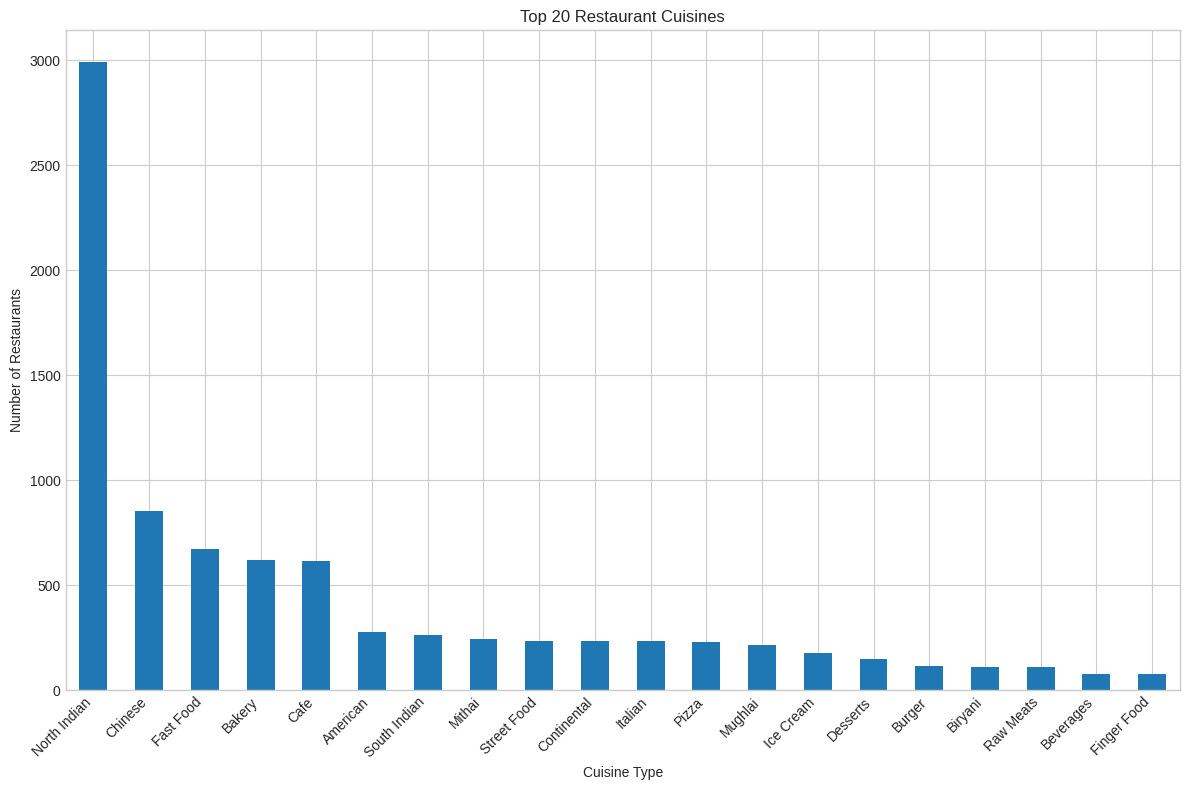

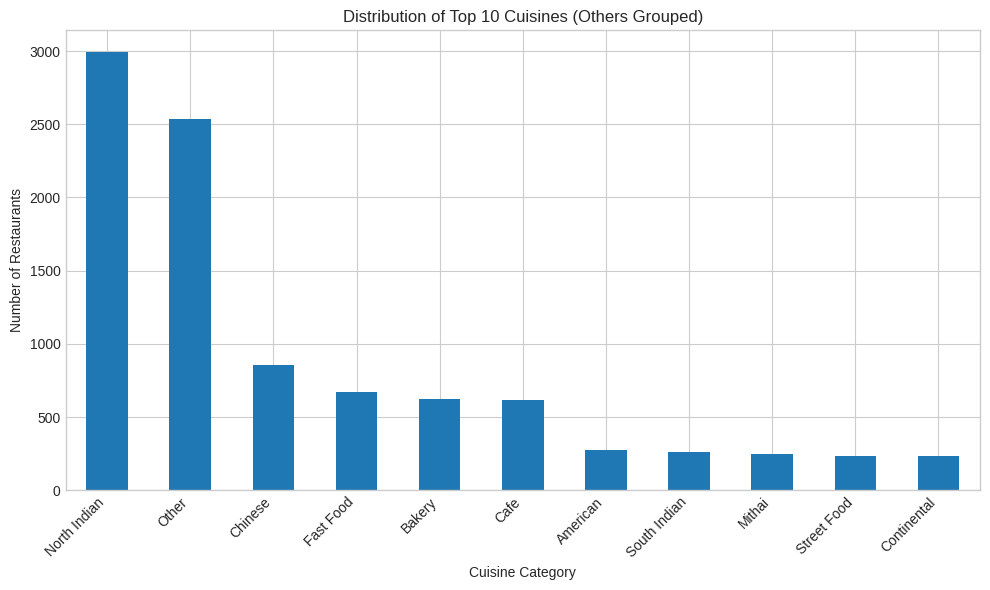


3. Preprocessing the data
Missing values in each column:
Cuisines    9
dtype: int64

Features selected for classification:
1. Country Code
2. City
3. Address
4. Locality
5. Locality Verbose
6. Longitude
7. Latitude
8. Average Cost for two
9. Currency
10. Has Table booking
11. Has Online delivery
12. Is delivering now
13. Switch to order menu
14. Price range
15. Aggregate rating
16. Rating color
17. Rating text
18. Votes

Categorical features: ['City', 'Address', 'Locality', 'Locality Verbose', 'Currency', 'Has Table booking', 'Has Online delivery', 'Is delivering now', 'Switch to order menu', 'Rating color', 'Rating text']
Numerical features: ['Country Code', 'Longitude', 'Latitude', 'Average Cost for two', 'Price range', 'Aggregate rating', 'Votes']
Encoded cuisine categories: {'American': 0, 'Bakery': 1, 'Cafe': 2, 'Chinese': 3, 'Continental': 4, 'Fast Food': 5, 'Mithai': 6, 'North Indian': 7, 'Other': 8, 'South Indian': 9, 'Street Food': 10}
Training set size: (7163, 18)
Testing se

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM Results:
Accuracy: 0.4204
Precision: 0.3287
Recall: 0.4204
F1 Score: 0.3104

Best model: Logistic Regression with F1 Score: 0.3391

5. Analyzing classification results

Detailed Classification Report:
              precision    recall  f1-score   support

    American       0.33      0.07      0.12        70
      Bakery       0.23      0.07      0.11       155
        Cafe       0.27      0.11      0.16       154
     Chinese       0.21      0.07      0.10       214
 Continental       0.28      0.08      0.13        59
   Fast Food       0.18      0.05      0.08       168
      Mithai       0.00      0.00      0.00        61
North Indian       0.42      0.77      0.54       748
       Other       0.45      0.51      0.48       634
South Indian       0.33      0.02      0.03        66
 Street Food       0.31      0.08      0.13        59

    accuracy                           0.40      2388
   macro avg       0.27      0.17      0.17      2388
weighted avg       0.35      0.40    

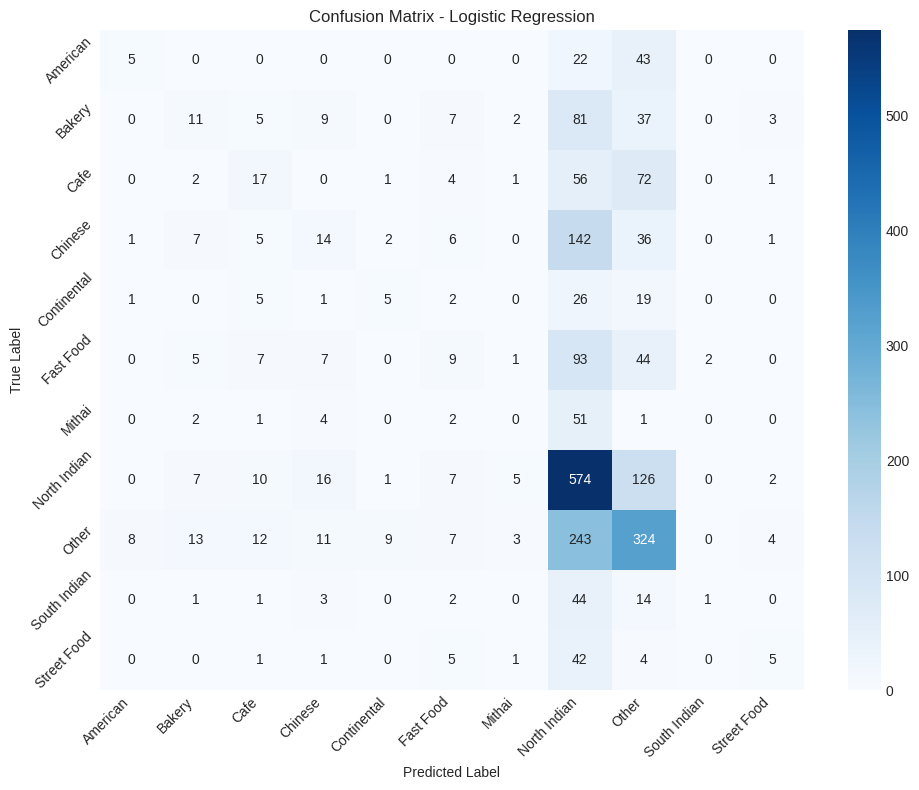


Performance metrics by cuisine:
         Cuisine  Precision    Recall  F1 Score  Test Examples
7   North Indian   0.417758  0.767380  0.540999            748
8          Other   0.450000  0.511041  0.478582            634
2           Cafe   0.265625  0.110390  0.155963            154
10   Street Food   0.312500  0.084746  0.133333             59
4    Continental   0.277778  0.084746  0.129870             59
0       American   0.333333  0.071429  0.117647             70
1         Bakery   0.229167  0.070968  0.108374            155
3        Chinese   0.212121  0.065421  0.100000            214
5      Fast Food   0.176471  0.053571  0.082192            168
9   South Indian   0.333333  0.015152  0.028986             66
6         Mithai   0.000000  0.000000  0.000000             61


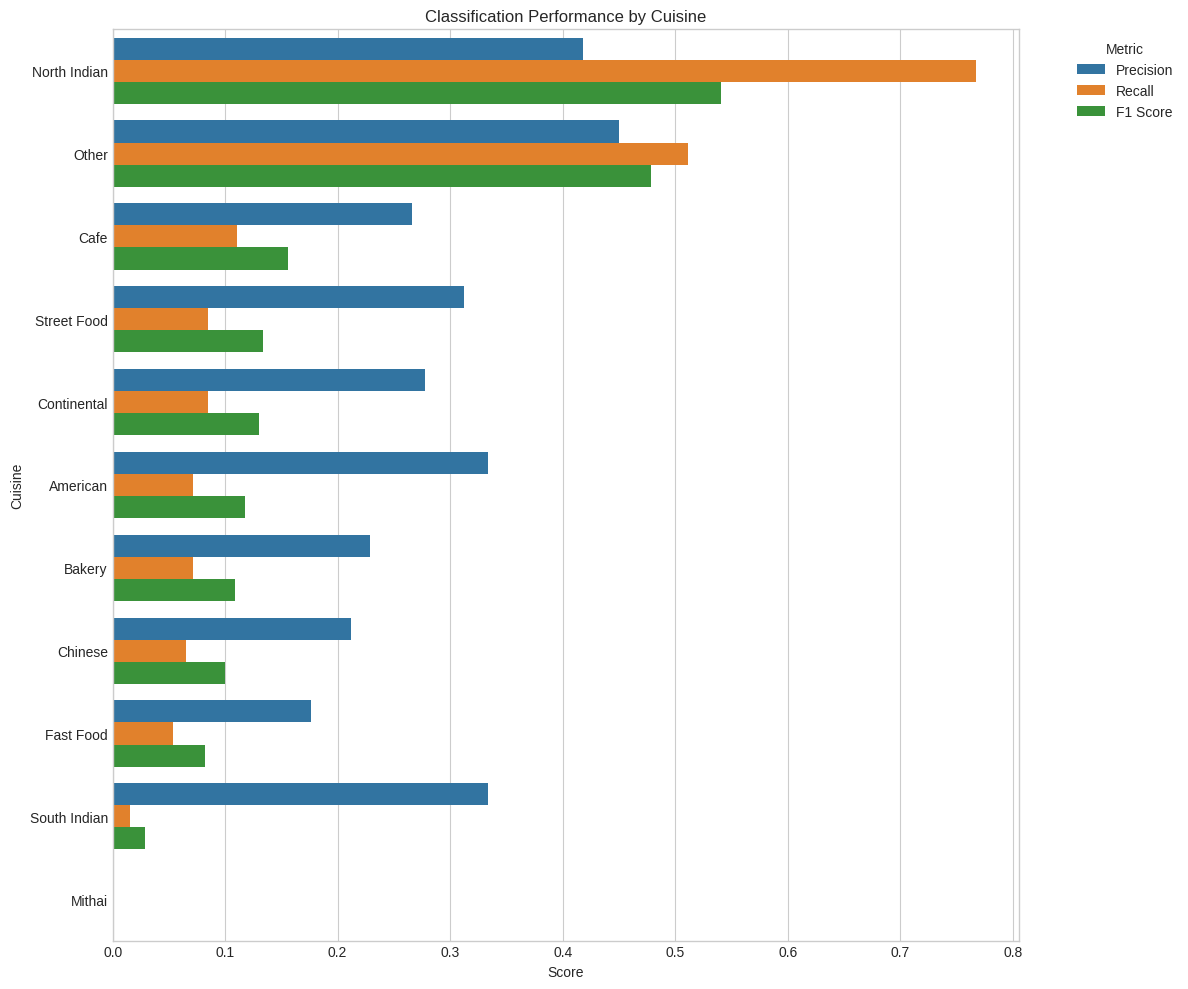


6. Analyzing feature importance
Feature importance analysis is only available for Random Forest, but the best model was Logistic Regression.

7. Analyzing misclassifications and class imbalance
Overall accuracy: 0.4041

Top 10 most confused cuisine pairs:
          Actual     Predicted  Count
58         Other  North Indian    243
21       Chinese  North Indian    142
49  North Indian         Other    126
34     Fast Food  North Indian     93
6         Bakery  North Indian     81
14          Cafe         Other     72
13          Cafe  North Indian     56
41        Mithai  North Indian     51
64  South Indian  North Indian     44
35     Fast Food         Other     44

Effect of class imbalance:


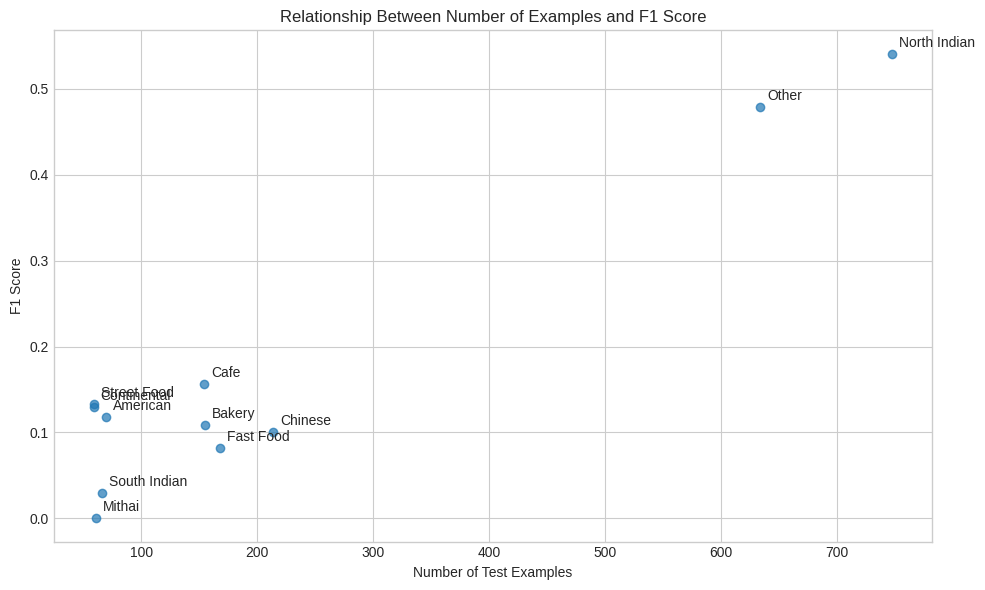


Analysis complete!


In [ ]:
# In the main section at the bottom, modify how arguments are handled
if __name__ == "__main__":
    # Check if file path is provided as command line argument
    # Ignore any IPython/Jupyter internal flags like -f
    import sys
    args = [arg for arg in sys.argv[1:] if not arg.startswith('-')]

    if args:
        file_path = args[0]
    else:
        # Default file path if not provided
        file_path = "Dataset.csv"
        print(f"No file path provided, using default: {file_path}")

    # Check if we're in Google Colab
    try:
        import google.colab
        from google.colab import files
        is_colab = True
        print("Running in Google Colab environment")
        # Allow file upload in Colab
        print("Please upload your dataset file:")
        uploaded = files.upload()
        if uploaded:
            file_path = list(uploaded.keys())[0]
            print(f"Using uploaded file: {file_path}")
    except (ImportError, ModuleNotFoundError):
        is_colab = False

    # Run the main function
    main(file_path)